In [1]:
!pip install gensim
!pip install tqdm
!pip install nltk
!pip install transformers
!pip install -U "ray[tune]"
!pip install sklearn
!pip install optuna
!pip install --user fastai

  Using cached gensim-4.2.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.10.31-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (757 kB)
  Using cached transformers-4.24.0-py3-none-any.whl (5.5 MB)
  Using cached huggingface_hub-0.10.1-py3-none-any.whl (163 kB)
  Using cached tokenizers-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
virtualenv 20.16.7 requires distlib<1,>=0.3.6, which is not installed.
ray 2.1.0 requires msgpack<2.0.0,>=1.0.0, which is not installed.
  Using cached msgpack-1.0.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (299 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cach

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

import gensim.downloader as api
from tqdm import tqdm
from nltk import word_tokenize
import torch
import multiprocessing

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, DistilBertForSequenceClassification
import sys

sys.path.insert(0, '/home/jupyter/src/natalies-little-helper/util')
import helpers as helper

In [3]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

In [4]:
data_path = "/home/jupyter/src/natalies-little-helper/data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

# yLabels = intent.negativereason.astype('category').cat.categories
print("Number of Negative Reasons: ", intent.negativereason.count())
intent.negativereason.value_counts()

Number of Negative Reasons:  9178


Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [5]:
intent = intent[intent['negativereason'].notna()]
intent.reset_index(drop=True, inplace=True)
num_labels = len(intent.negativereason.unique())

rmap = {reason: i for i, reason in enumerate(intent.negativereason.unique())}
imap = {i: reason for reason, i in rmap.items()}

yLabels = [imap[i] for i in range(len(imap))]

intent.negativereason = intent.negativereason.apply(lambda x: rmap[x])

## Select Samples

In [6]:
intent.intentGroup.value_counts()

Customer Service    4098
Flights             3092
Can't Tell          1190
Luggage              798
Name: intentGroup, dtype: int64

In [7]:
N_SAMPLES = 798
intent_groups_df = intent.groupby('intentGroup').apply(lambda x: x.sample(n=N_SAMPLES)).reset_index(drop=True)
intent_group_labels = intent.intentGroup.astype('category').cat.categories
intent_group_map = {group: i for i, group in enumerate(intent_group_labels)}
intent_groups_df.intentGroup = intent_groups_df.intentGroup.apply(lambda x: intent_group_map[x])

In [8]:
intent_groups_df.intentGroup.value_counts()

0    798
1    798
2    798
3    798
Name: intentGroup, dtype: int64

## Split Train and Test Data

In [9]:
vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.9999, ngram_range=(1,3), max_features=10000)
X = vectorizer.fit_transform(intent.text)

scaler = StandardScaler(with_mean=False)
scaler.fit(X)

xTrain, xTest, yTrain, yTest = train_test_split(X, intent.negativereason, train_size=0.8, stratify=intent.negativereason)

In [10]:
XGroup = vectorizer.fit_transform(intent_groups_df.text)
xGroupTrain, xGroupTest, yGroupTrain, yGroupTest = train_test_split(XGroup, intent_groups_df.intentGroup, train_size=0.8, stratify=intent_groups_df.intentGroup)

# Base Classifiers

## Perceptron

### Intent Reasons

In [11]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xTrain), yTrain)
# clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# precisions = precision_score(yTest, yPred, average=None)
# recalls = recall_score(yTest, yPred, average=None)
# f1s = f1_score(yTest, yPred, average=None)

# helper.evaluate_score(yTest, yPred)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.37      0.31      0.34       116
           1       0.39      0.39      0.39       238
           2       0.68      0.69      0.68       333
           3       0.63      0.70      0.66       582
           4       0.51      0.30      0.38       106
           5       0.62      0.66      0.64       145
           6       0.42      0.20      0.27        96
           7       0.79      0.70      0.74       169
           8       0.04      0.20      0.07        15
           9       0.32      0.17      0.22        36

    accuracy                           0.57      1836
   macro avg       0.47      0.43      0.44      1836
weighted avg       0.57      0.57      0.57      1836



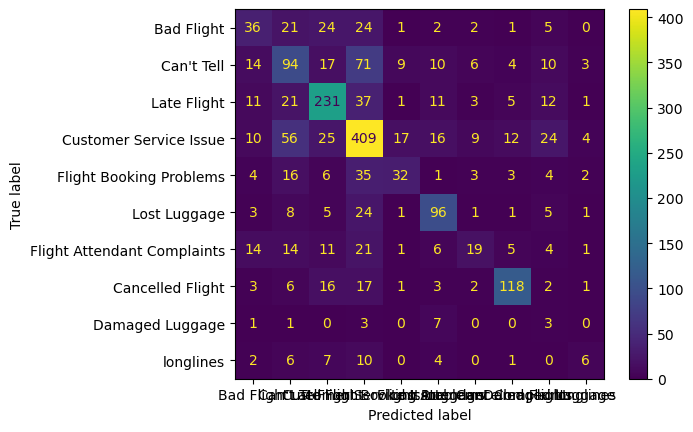

array([3, 2, 0, ..., 6, 3, 2])

In [12]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [13]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xGroupTrain), yGroupTrain)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.52      0.57      0.54       160
           1       0.56      0.52      0.54       160
           2       0.64      0.65      0.65       159
           3       0.82      0.77      0.79       160

    accuracy                           0.63       639
   macro avg       0.63      0.63      0.63       639
weighted avg       0.63      0.63      0.63       639



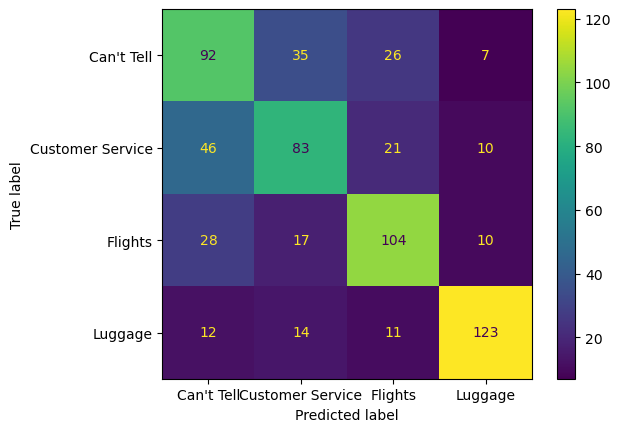

In [14]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## Logistic Regression

### Intent Reasons

In [15]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTest)

helper.evaluate_score(yTest, yPred)

Accuracy:	 0.605119825708061
Precision:	 [0.47058824 0.42173913 0.65616798 0.59354839 0.66       0.744
 0.48837209 0.79861111 0.         0.66666667]
Recall: 	 [0.34482759 0.40756303 0.75075075 0.79037801 0.31132075 0.64137931
 0.21875    0.68047337 0.         0.05555556]
F1 scores:	 [0.39800995 0.41452991 0.70028011 0.6779661  0.42307692 0.68888889
 0.30215827 0.73482428 0.         0.1025641 ]
Average
	Precision: 0.6005447959388903
	Recall: 0.605119825708061
	F1: 0.5850853325548321


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1836
1836
{0, 1, 2, 3, 4, 5, 6, 7, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
              precision    recall  f1-score   support

           0       0.47      0.34      0.40       116
           1       0.42      0.41      0.41       238
           2       0.66      0.75      0.70       333
           3       0.59      0.79      0.68       582
           4       0.66      0.31      0.42       106
           5       0.74      0.64      0.69       145
           6       0.49      0.22      0.30        96
           7       0.80      0.68      0.73       169
           8       0.00      0.00      0.00        15
           9       0.67      0.06      0.10        36

    accuracy                           0.61      1836
   macro avg       0.55      0.42      0.44      1836
weighted avg       0.60      0.61      0.59      1836



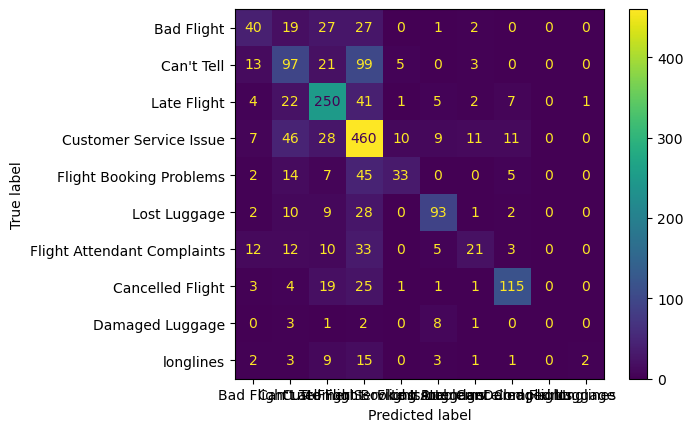

array([3, 2, 0, ..., 3, 3, 2])

In [16]:
print(len(yPred))
print(len(yTest))
ySet = {y for y in yPred}
yTSet = {y for y in yTest}
print(ySet)
print(yTSet)
# helper.evaluate_score([0,1,2,3,4], [1,2,0,3,3])
# helper.evaluate_score(yTest, yPred)
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [17]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xGroupTrain, yGroupTrain)

LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.56      0.62      0.59       160
           1       0.63      0.57      0.60       160
           2       0.67      0.67      0.67       159
           3       0.82      0.81      0.82       160

    accuracy                           0.67       639
   macro avg       0.67      0.67      0.67       639
weighted avg       0.67      0.67      0.67       639



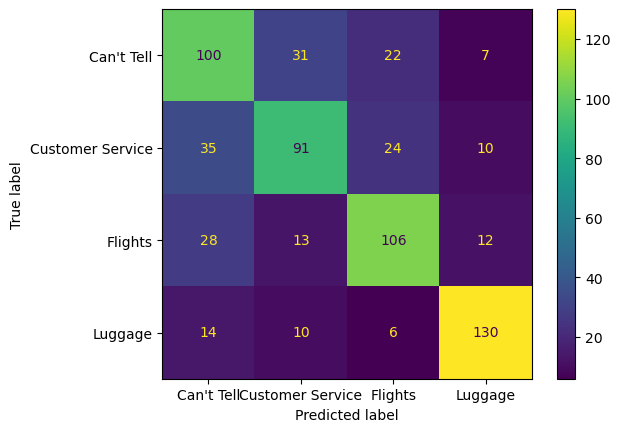

In [18]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## SVC

### Intent Reasons

In [19]:
clf = LinearSVC()
clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# helper.evaluate_score(yTest, yPred)

LinearSVC()

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       116
           1       0.42      0.38      0.40       238
           2       0.63      0.68      0.65       333
           3       0.63      0.75      0.68       582
           4       0.49      0.32      0.39       106
           5       0.70      0.71      0.70       145
           6       0.42      0.25      0.31        96
           7       0.74      0.73      0.73       169
           8       0.50      0.13      0.21        15
           9       0.67      0.17      0.27        36

    accuracy                           0.59      1836
   macro avg       0.56      0.45      0.47      1836
weighted avg       0.58      0.59      0.58      1836



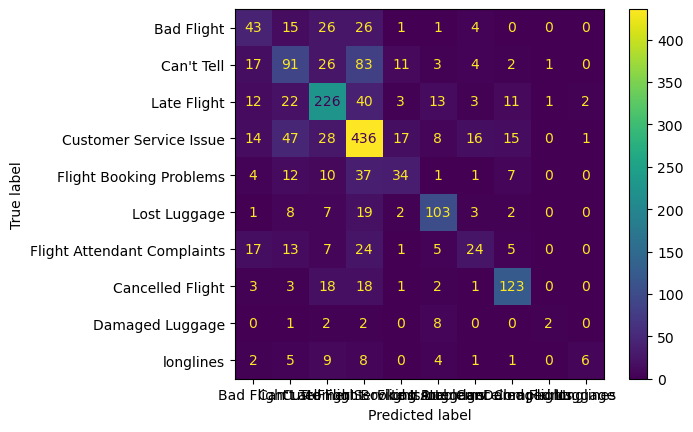

array([3, 2, 0, ..., 7, 5, 2])

In [20]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [21]:
clf = LinearSVC()
clf.fit(xGroupTrain, yGroupTrain)

LinearSVC()

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       160
           1       0.62      0.60      0.61       160
           2       0.70      0.70      0.70       159
           3       0.83      0.84      0.83       160

    accuracy                           0.69       639
   macro avg       0.68      0.69      0.68       639
weighted avg       0.68      0.69      0.68       639



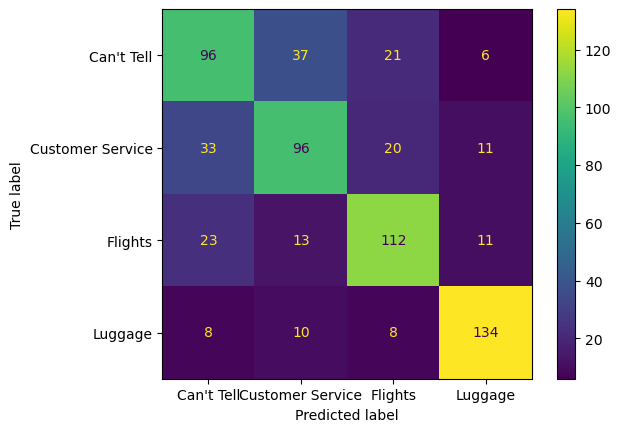

In [22]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

# Advance Models

In [23]:
from fastai.text.all import *
from fastai import *

In [24]:
# data_lm = (TextList
#            .from_csv(path, data_path + 'Tweets.csv', cols='text')
#            #Where are the text? Column 'text' of tweets.csv
#            .split_by_rand_pct(0.2)
#            #How to split it? Randomly with the default 20% in valid
#            .label_for_lm()
#            #Label it for a language model
#            .databunch(bs=48))
#            #Finally we convert to a DataBunch
# data_lm.show_batch()

train= pd.read_csv(data_path + 'Tweets.csv')

data_lm = DataBlock(
        blocks=TextBlock.from_df('text', is_lm=True),
        get_x=ColReader('text'),
        splitter=RandomSplitter(0.2)
)

data_lm = data_lm.dataloaders(train, bs=10, seq_len=72, device=torch.device('cuda'))
data_lm.show_batch()

,text,text_
0,"xxbos @united now maintenance issues with flight xxunk and more issues with passengers that will miss connections needing to get off xxbos @americanair xxunk at xxup sfo and going to xxup lax . xxbos @southwestair has some of the best airfare prices ! xxmaj got ta xxup luv them :) xxbos @jetblue thank you ! xxbos @southwestair yeah , all 4 are rebooked for tomorrow xxup am . xxmaj hoping the 3rd","@united now maintenance issues with flight xxunk and more issues with passengers that will miss connections needing to get off xxbos @americanair xxunk at xxup sfo and going to xxup lax . xxbos @southwestair has some of the best airfare prices ! xxmaj got ta xxup luv them :) xxbos @jetblue thank you ! xxbos @southwestair yeah , all 4 are rebooked for tomorrow xxup am . xxmaj hoping the 3rd time"
1,"he takes notes . i would never choose to fly xxmaj united again . xxbos @usairways xxmaj she spoke with someone this xxup am and was told that breast xxunk are n't medical equipment and that she should have "" planned better . "" xxbos @usairways ok my 4th try today … xxunk up at xxunk after xxunk minute hold time . # terrible http : / / t.co / xxunk xxbos","takes notes . i would never choose to fly xxmaj united again . xxbos @usairways xxmaj she spoke with someone this xxup am and was told that breast xxunk are n't medical equipment and that she should have "" planned better . "" xxbos @usairways ok my 4th try today … xxunk up at xxunk after xxunk minute hold time . # terrible http : / / t.co / xxunk xxbos @united"
2,"xxmaj why does it take 4 - 6 weeks for a new mileageplus xxmaj premier card to be sent out ? # stillwaiting # xxunk xxbos @usairways need to learn operations . xxmaj sit a plane overnight at # gsp , and not realize there 's a mech problem . xxmaj then delay flight 3 1 / 2 hours ! xxbos @americanair from a service rep but that has n't happened yet","why does it take 4 - 6 weeks for a new mileageplus xxmaj premier card to be sent out ? # stillwaiting # xxunk xxbos @usairways need to learn operations . xxmaj sit a plane overnight at # gsp , and not realize there 's a mech problem . xxmaj then delay flight 3 1 / 2 hours ! xxbos @americanair from a service rep but that has n't happened yet ."
3,"want to check flight 304 plane from xxmaj houston . xxmaj that sound was during takeoff & & landing http : / / t.co / xxunk xxbos @americanair xxmaj cancelled xxmaj flighted flights , now xxmaj i 'm rerouted and have over 12 hrs of travel but you will bump paying customers for non revs . # custserv xxbos @united xxmaj cool . xxmaj thank you . xxbos @usairways can i get","to check flight 304 plane from xxmaj houston . xxmaj that sound was during takeoff & & landing http : / / t.co / xxunk xxbos @americanair xxmaj cancelled xxmaj flighted flights , now xxmaj i 'm rerouted and have over 12 hrs of travel but you will bump paying customers for non revs . # custserv xxbos @united xxmaj cool . xxmaj thank you . xxbos @usairways can i get an"
4,"ever xxbos @americanair i xxunk on hold for 2 hrs to resolve my flight schedule & & your system hung up on me . # unhappycustomer xxbos @jetblue it 's been 3 hours , why have you not sent the plane from the hangar for flight xxunk at xxup jfk ? xxmaj this is absolutely ridiculous . xxbos xxmaj made it to # xxmaj costa # xxmaj rica and back @jetblue xxmaj","xxbos @americanair i xxunk on hold for 2 hrs to resolve my flight schedule & & your system hung up on me . # unhappycustomer xxbos @jetblue it 's been 3 hours , why have you not sent the plane from the hangar for flight xxunk at xxup jfk ? xxmaj this is absolutely ridiculous . xxbos xxmaj made it to # xxmaj costa # xxmaj rica and back @jetblue xxmaj missing"
5,"xxmaj how can we get it back ? xxmaj thanks ! xxbos @united screwing me over twice in one month . xxmaj learned my lesson . xxmaj we are through . xxbos @americanair xxmaj hi , can you please ticket my award ticket ? xxmaj the status is "" on xxmaj request "" now . xxmaj thanks . x

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# learn.model = learn.cuda()
# #find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot();

In [ ]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

# Distilbert Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", Truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

In [ ]:
data_og = pd.concat([intent.text, intent.negativereason], axis=1)

data = []
for t in data_og.iterrows():
    temp = {}
    temp["text"] = t[1].text
    temp["label"] = t[1].negativereason
    temp.update(tokenizer(t[1].text))
    data.append(temp)

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels, force_download=True, cache_dir="/home/jupyter/cache/")

training_args = TrainingArguments(
    output_dir="./intent_results",
    learning_rate=2e-5,
    evaluation_strategy = "steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
    eval_steps=100
)

trainer_tuned = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
best_run = trainer_tuned.hyperparameter_search(n_trials=1, direction="maximize")

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer_tuned.args, n, v)

trainer_tuned.train()

In [ ]:
preds = trainer_tuned.predict(test_dict)

In [ ]:
yTrue = [t["label"] for t in test_dict]
yPred = [p.argmax() for p in preds[0]]
helper.evaluate_score(yTrue, yPred)